In [43]:
import soundfile as sf
data1,samplerate = sf.read('E:\Research ODAS\Postfiltered\postfiltered_2020-01-08_09_25_03_1.raw', 
               channels=4, 
               samplerate=16000,
               subtype='PCM_16'
              )
data2,samplerate = sf.read('E:\Research ODAS\Postfiltered\postfiltered_2020-01-08_09_25_03_3.raw', 
               channels=4, 
               samplerate=16000,
               subtype='PCM_16'
              )

In [113]:
#0213 gcc-phat transform
def gcc_phat(sig1, sig2, fs=16000, max_tau=None, interp=1):
    '''
    This function computes the offset between the signal sig and the reference signal refsig
    using the Generalized Cross Correlation - Phase Transform (GCC-PHAT)method.
    '''
    
    # make sure the length for the FFT is larger or equal than len(sig) + len(refsig)
    n = sig1.shape[0] 

    # Generalized Cross Correlation Phase Transform
    SIG = np.fft.rfft(sig1, n=n)
    SIG2 = np.fft.rfft(sig2, n=n)
    R = SIG * np.conj(SIG2)

    cc = np.fft.irfft(R / np.abs(R), n=(interp * n))

    max_shift = int(interp * n / 2)
    if max_tau:
        max_shift = np.minimum(int(interp * fs * max_tau), max_shift)

    cc = np.concatenate((cc[-max_shift:], cc[:max_shift+1]))

    # find max cross correlation index
    shift = np.argmax(np.abs(cc)) - max_shift

    tau = np.float(shift / float(interp * fs))
    
    return tau, cc, R, SIG, SIG2

In [ ]:
x1 = np.array([1,2,3,4,5,6,7,8])
x1.np.fft.rfft

In [126]:
def truncate(sig1, sig2):
    l1, l2 = len(sig1), len(sig2)
    if l1 <= l2:
        return sig1, sig2[0:l1]
    else:
        return sig1[0:l2], sig2
    
sig1, sig2 = truncate(data1[:,0], data2[:,0])
windowDuration, Fs = 1, 16000
window = np.hanning(16000)
max_tau = 5/340
# The number of samples in each window
l = windowDuration * Fs
N = len(sig1)
for i in range(98,99):
    sig1Temp, sig2Temp = sig1[i*l:l*(i+1)], sig2[i*l:l*(i+1)]
tau, cc, R, SIG, SIG2 = gcc_phat(sig1Temp*window, sig2Temp*window, fs=16000, max_tau=max_tau, interp=1)

In [127]:
tau

-0.001

In [3]:
# Truncate signal, based on the signal that has the shorter length
def truncate(sig1, sig2):
    l1, l2 = len(sig1), len(sig2)
    if l1 <= l2:
        return sig1, sig2[0:l1]
    else:
        return sig1[0:l2], sig2

# PHAT Transfrorm 
def phatTransform(sig1, sig2, windowDuration, Fs, ):
    # Fs: Sampling Frequency
    # WindowDuration: the length of moving window in time (s)
    l = windowDuration * Fs
    N = len(sig1)
    # Padding
    if N%l != 0:
        padWidth = l-N%l
        sig1 = np.pad(sig1, (0, padWidth), 'constant', constant_values = 0)
        sig2 = np.pad(sig2, (0, padWidth), 'constant', constant_values = 0)
    numOfWindows = len(sig1)/l
    for i in range(0,numOfWindows):
        sig1Temp, sig2Temp = sig1[i*l:l*(i+1)], sig2[i*l:l*(i+1)]
        Fsig1 = np.fft.fft(sig1Temp)
        Fsig2 = np.fft.fft(sig2Temp)
        # Normalize magnitude to 1
        phat1 = np.exp(1j*np.angle(Fsig1))
        phat2 = np.exp(1j*np.angle(Fsig2))
        # Element wise multiplication
        product = np.multiply(phat1, phat2)
        # Inverse fourier transform
        IFFT = np.abs(np.fft.ifft(product))
        # Statistics
        maxValue, argmax, mean, std = max(IFFT), np.argmax(IFFT), np.mean(IFFT), np.std(IFFT)
        significance = (maxValue - mean) / std
        normalized = (IFFT-mean)/std
    

In [4]:
import numpy as np
from scipy import signal

# Truncate signal, based on the signal that has the shorter length
def truncate(sig1, sig2):
    l1, l2 = len(sig1), len(sig2)
    if l1 <= l2:
        return sig1, sig2[0:l1]
    else:
        return sig1[0:l2], sig2
    
sig1, sig2 = truncate(data1[:,0], data1[:,0])

windowDuration, Fs = 1, 16000
# The number of samples in each window
l = windowDuration * Fs
N = len(sig1)
# Padding
if N%l != 0:
    padWidth = l-N%l
    sig1 = np.pad(sig1, (0, padWidth), 'constant', constant_values = 0)
    sig2 = np.pad(sig2, (0, padWidth), 'constant', constant_values = 0)
    
numOfWindows = len(sig1)/l
for i in range(100,101):
    sig1Temp, sig2Temp = sig1[i*l:l*(i+1)], sig2[i*l:l*(i+1)]
    [f,crossSpectrum] = signal.csd(sig1Temp, sig2Temp, 
                                   nperseg=l,                   
                                   fs=16000.0, 
                                   window='hamming',
                                   return_onesided=False, 
                                   scaling='spectrum')
    weight = 1/np.abs(crossSpectrum)
    Rxy = np.fft.ifft(np.multiply(weight,crossSpectrum))
    
    
    
#     Fsig1 = np.fft.fft(sig1Temp)
#     Fsig2 = np.fft.fft(sig2Temp)
    
#     phat1 = np.exp(1j*np.angle(Fsig1))
#     phat2 = np.exp(1j*np.angle(Fsig2))
    
    
#     product = np.multiply(phat1, np.conj(phat2))
#     result = np.abs(signal.correlate(phat1,phat2))
#     IFFT = np.abs(np.fft.ifft(result))
    
# maxValue, argmax, mean, std = max(IFFT), np.argmax(IFFT), np.mean(IFFT), np.std(IFFT)
# significance = (maxValue - mean) / std
# normalized = (IFFT-mean)/std    

C:\Users\lenovo\Anaconda3\lib\site-packages\ipykernel_launcher.py:33: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\lenovo\Anaconda3\lib\site-packages\ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in multiply


In [5]:
len(Rxy)

16000

In [6]:
sig1Temp = (10**(-1))*np.ones(16000)
[f,crossSpectrum] = signal.csd(sig1Temp, sig1Temp, 
                               nperseg=l,                   
                               fs=16000.0, 
                               window='hamming',
                               return_onesided=False, 
                               scaling='spectrum')
weight = 1/np.abs(crossSpectrum)
Rxy = np.fft.ifft(np.multiply(weight,crossSpectrum))

C:\Users\lenovo\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in true_divide
  
C:\Users\lenovo\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in multiply
  if __name__ == '__main__':


In [7]:
np.argmin(crossSpectrum)

125

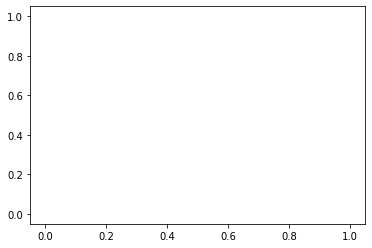

In [9]:
import matplotlib.pyplot as plt
plt.plot(Rxy[100:2000])

In [14]:
x = np.array([1,2,3,4,5,6,7,8])

In [17]:
x[:4]

array([1, 2, 3, 4])